<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-description" data-toc-modified-id="Data-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data description</a></span></li><li><span><a href="#Importing-libraries-and-data" data-toc-modified-id="Importing-libraries-and-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing libraries and data</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Data-Validation" data-toc-modified-id="Data-Validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Validation</a></span></li><li><span><a href="#Image-Vectorization" data-toc-modified-id="Image-Vectorization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Image Vectorization</a></span></li><li><span><a href="#Text-Vectorization" data-toc-modified-id="Text-Vectorization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Text Vectorization</a></span></li><li><span><a href="#Combining-vectors" data-toc-modified-id="Combining-vectors-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Combining vectors</a></span></li><li><span><a href="#Training-a-predictive-model-for-matching" data-toc-modified-id="Training-a-predictive-model-for-matching-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training a predictive model for matching</a></span><ul class="toc-item"><li><span><a href="#Linear-models" data-toc-modified-id="Linear-models-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Linear models</a></span></li><li><span><a href="#Neuron-net" data-toc-modified-id="Neuron-net-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Neuron net</a></span></li></ul></li><li><span><a href="#Model-testing" data-toc-modified-id="Model-testing-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model testing</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Searching for images by text query

## Data description

The `train_dataset.csv` file contains the information necessary for training: image file name, description identifier and description text. Up to 5 descriptions can be available for one image. The description identifier has the format <image file name>#<order number of description>.

The `train_images` folder contains images for model training.

The `CrowdAnnotations.tsv` file contains the crowdsourced image and description matching data. The column numbers and the corresponding data type are:

1. image file name.
2. description identifier.
3. Percentage of people who confirmed that the description matches the image.
4. Number of people who confirmed that the description matches the image.
5. Number of people who confirmed that the description does not match the image.

The `ExpertAnnotations.tsv` file contains the image and description matching data from the expert survey. The column numbers and the corresponding data type are:

1. image file name.
2. description identifier.
3, 4, 5 - scores of three experts.

The experts give marks on a scale from 1 to 4, where 1 - the image and the query do not correspond at all, 2 - the query contains elements of the image description, but in general the query does not correspond to the text, 3 - the query and the text correspond with accuracy to some details, 4 - the query and the text correspond completely.

The `test_queries.csv` file contains information necessary for testing: query ID, query text and relevant image. Up to 5 descriptions can be available for one image. The description identifier has the format <image filename>#<order number of description>.

The `test_images` folder contains images for model testing.


## Importing libraries and data

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import transformers as tfs
import random
import pickle
from tqdm import tqdm, notebook, trange
# --------------------------------------------
import torch
import torch.nn as nn
from torch import cuda
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
from PIL import Image
from torchvision import datasets, transforms, models
from torchmetrics import MeanSquaredError

import time
import helper
import os
import gc
from textwrap import wrap

from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit, train_test_split, GridSearchCV

from scipy.spatial.distance import cosine
# from skimage import io, transform

In [46]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

# Fixing random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# PATH = r'C:\Users\jcbhf\PycharmProjects\pythonProject1\to_upload'
# PATH = '/Users/user/Desktop/Сборный/to_upload'
PATH = '/kaggle/input/yandex-sborny'

CUDA is available!  Training on GPU ...


In [47]:
save_path = '/kaggle/working/'
def save_to_pkl(data, file_name):
    with open(f'{save_path}/{file_name}.pkl', 'wb') as f:
          pickle.dump(data, f)
    print(f'Saved to {save_path}/{file_name}.pkl')

def load_from_pkl(file_name):
    loaded_data = pickle.load(open(f'{PATH}/{file_name}.pkl', 'rb'))
    return loaded_data

In [48]:
# !unzip /content/train_images.zip

In [49]:
# !unzip /content/test_images.zip

## Exploratory Data Analysis

Our dataset contains expert and crowdsourced evaluations of text-image correspondence.

In the file with expert opinions, there are evaluations from three experts for each image-text pair. 

In the file with crowdsourced evaluations, the information is arranged in this order:

* Percentage of performers who confirmed that the text corresponds to the image.
* Number of executors who confirmed that the text corresponds to the picture.
* Number of performers who confirmed that the text does not match the picture.

Model should return as output the probability that the image matches the text, so the target variable should have values between 0 and 1.

In [50]:
train_dataset = pd.read_csv(f'{PATH}/train_dataset.csv')
test_images = pd.read_csv(f'{PATH}//test_images.csv')
test_queries = pd.read_csv(f'{PATH}/test_queries.csv', sep='|', index_col=0)


expert_annotations = pd.read_csv(f'{PATH}/ExpertAnnotations.tsv', delimiter='\t', header=None)
expert_annotations.columns = ['image', 'query_id', 'exp_1', 'exp_2', 'exp_3']
crowd_annotations = pd.read_csv(f'{PATH}/CrowdAnnotations.tsv', delimiter='\t', header=None)
crowd_annotations.columns = ['image', 'query_id', 'conf_rate', 'confirm', 'not_confirm']

In [51]:
# The function outputs the necessary information about the data
def show_info_about(dataset):
    print(dataset.info())
    display(dataset.head())

In [52]:
show_info_about(train_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [53]:
show_info_about(test_queries)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
None


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [54]:
show_info_about(expert_annotations)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB
None


image                     query_id  exp_1  exp_2  exp_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1      2

To calculate the aggregate expert evaluation, we take the median evaluation of all experts. 

Let's use min-max scaling to translate the estimates into the range [0,1] 

**Look at the number of unique images**

In [55]:
print("Number of unique images in the train set", train_dataset.image.nunique())
print("Number of unique images in the test set", test_queries.image.nunique())

Количество уникальных изображений в обучающем наборе 1000
Количество уникальных изображений в тестовом наборе 100


**Look at the number of unique texts**


In [56]:
print("Number of unique text in the train set", train_dataset.query_text.nunique())
print("Number of unique text in the test set", test_queries.query_text.nunique())

Количество уникальных описаний в обучающем наборе 977
Количество уникальных описаний в тестовом наборе 500


**Number of queries**

In [57]:
print("Number of unique queries (query_id) in expert_annotations:", expert_annotations.query_id.nunique())
print("Number of unique queries (query_id) in crowd_annotations:", crowd_annotations.query_id.nunique())

Количество уникальных запросов (query_id) в expert_annotations: 977
Количество уникальных запросов (query_id) в crowd_annotations: 1000


In [58]:
expert_annotations['exp_total'] = (expert_annotations[['exp_1', 'exp_2', 'exp_3']]).median(axis=1)

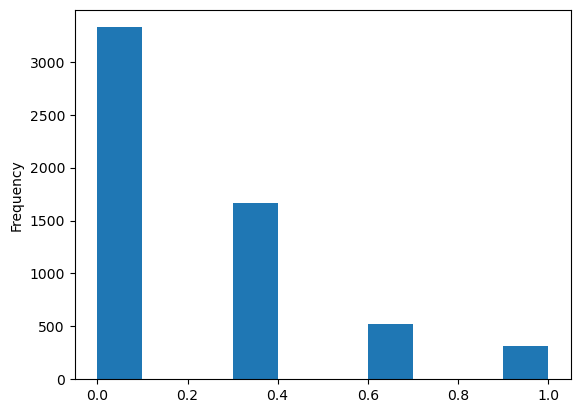

In [59]:
# apply normalization techniques by Column 1
expert_annotations['exp_norm'] = (expert_annotations['exp_total'] - expert_annotations['exp_total'].min()) / (expert_annotations['exp_total'].max() - expert_annotations['exp_total'].min())    
  
# view normalized data
expert_annotations['exp_norm'].plot.hist()
plt.show()

**Most of the images in the dataset do not match the description**

In [60]:
show_info_about(crowd_annotations)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47830 non-null  object 
 1   query_id     47830 non-null  object 
 2   conf_rate    47830 non-null  float64
 3   confirm      47830 non-null  int64  
 4   not_confirm  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None


image                     query_id  conf_rate  confirm  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0        3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0        0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0        0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0        0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0        0   

   not_confirm  
0            0  
1            3  
2            3  
3            3  
4            3

In [61]:
train_data = train_dataset\
    .merge(expert_annotations[['image', 'query_id', 'exp_norm']], how='left', on=['image', 'query_id'])\
    .merge(crowd_annotations[['image', 'query_id', 'conf_rate']], how='outer', on=['image', 'query_id'])
train_data.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  exp_norm  conf_rate  
0  A young child is wearing blue goggles and sitt...  0.000000        0.0  
1  A young child is wearing blue goggles and sitt...  0.000000        NaN  
2  A young child is wearing blue goggles and sitt...  0.333333        0.0  
3  A young child is wearing blue goggles and sitt...  1.000000        1.0  
4  A young child is wearing blue goggles and sitt...  0.000000        NaN

In [62]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  5822 non-null   object 
 3   exp_norm    5822 non-null   float64
 4   conf_rate   47830 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.3+ MB


In [63]:
query_id_text_corresp = train_dataset[['query_id', 'query_text']].drop_duplicates()

train_data = train_data.drop(columns=['query_text']).merge(query_id_text_corresp, how="left", on=['query_id'])


In [64]:
train_data['target'] = train_data[['conf_rate', 'exp_norm']].mean(axis=1)
train_data = train_data.drop(columns=['conf_rate', 'exp_norm'])
train_data.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text    target  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A young child is wearing blue goggles and sitt...  0.000000  
2  A young child is wearing blue goggles and sitt...  0.166667  
3  A young child is wearing blue goggles and sitt...  1.000000  
4  A young child is wearing blue goggles and sitt...  0.000000

In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


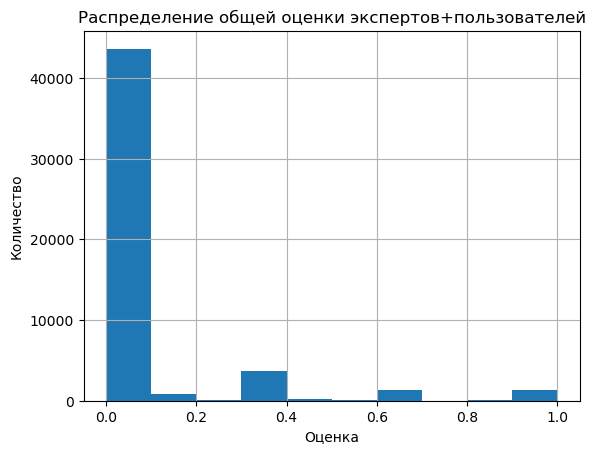

In [66]:
train_data['target'].hist()
plt.title('Distribution of total expert+user evaluation')
plt.xlabel('Evaluation')
plt.ylabel('Amount');

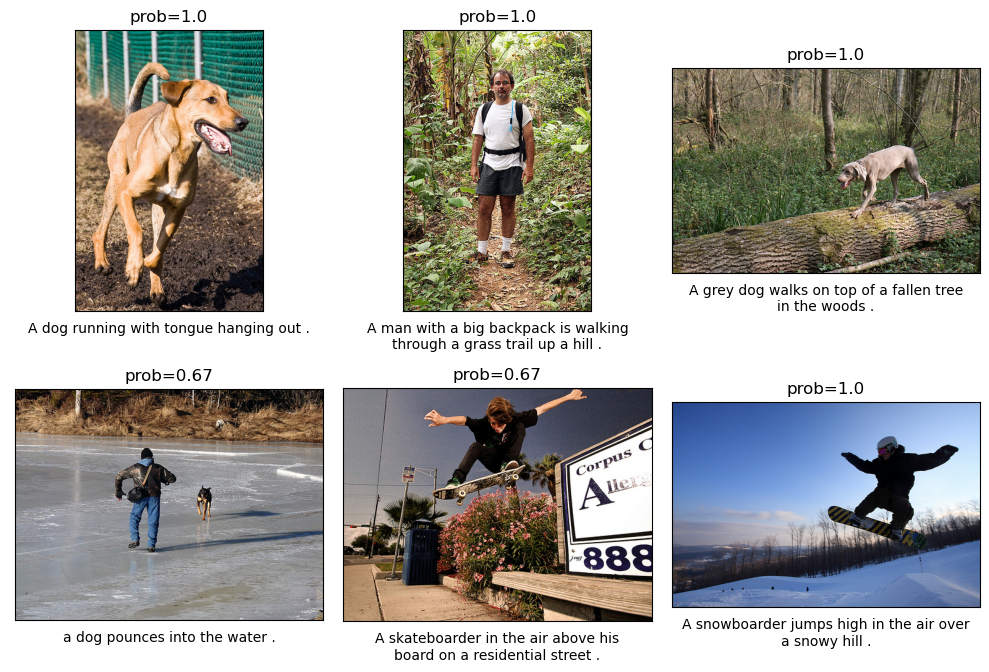

In [67]:
sample_data = train_data.sample(n=2000, random_state=0)
negative = sample_data[sample_data['target'] <= 0.5]
positive = sample_data[sample_data['target'] > 0.5]
fig = plt.figure(figsize=(10,10))
for i in range(6):
    fig.add_subplot(3, 3, i+1)
    img_name = positive.iloc[i]['image']
    img_text = positive.iloc[i]['query_text']
    img_text = '\n'.join(wrap(img_text, 40))

    img_target = positive.iloc[i]['target']
    img = mpimg.imread(f'{PATH}/train_images/train_images/{img_name}')
    plt.imshow(img)
    plt.title(f'prob={round(img_target, 2)}')
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

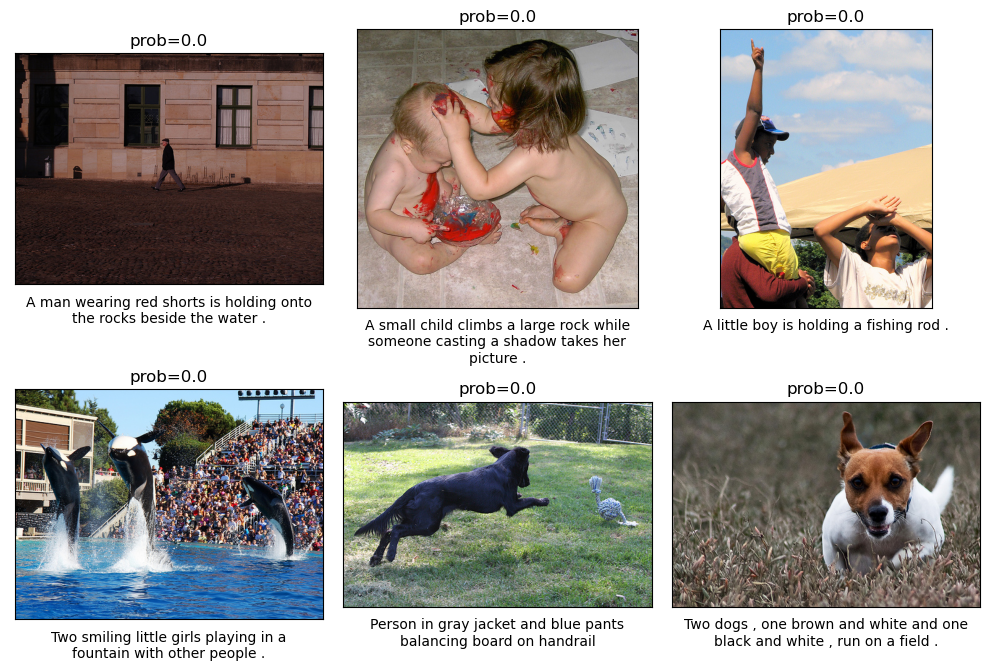

In [68]:
fig = plt.figure(figsize=(10,10))
for i in range(6):
    fig.add_subplot(3, 3, i+1)
    img_name = negative.iloc[i]['image']
    img_text = negative.iloc[i]['query_text']
    img_text = '\n'.join(wrap(img_text, 40))
    img_target = negative.iloc[i]['target']
    img = mpimg.imread(f'{PATH}/train_images/train_images/{img_name}')
    plt.imshow(img)
    plt.title(f'prob={round(img_target, 2)}')
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Data Validation

In some countries where your company operates, there are restrictions on image processing: Search and search services are prohibited from providing any information, including but not limited to text, images, video and audio containing a description, image or recording of a child's voice, without the permission of a parent or legal representative. A child is defined as anyone under the age of 16.

Your service strictly follows the laws of the countries in which it operates. Therefore, when you try to view images that are prohibited by law, a disclaimer is shown instead of pictures:

> This image is unavailable in your country in compliance with local laws
> 

However, your PoC does not have this functionality. Therefore, all images that violate this law must be removed from the training sample.

In [69]:
prohibit_wordlist = ['girl', 
                     'boy', 
                     'child', 
                     'children', 
                     'baby', 
                     'young', 
                     'teen', 
                     'teenager', 
                     'kid', 
                     'toddler', 
                     'minor', 
                     'youth', 
                     'junior']

In [70]:
def delete_prohib_words(string, prohibit_wordlist):
    prohibit_wordlist = prohibit_wordlist
    lst = string.split(' ')
    if len(set(lst).intersection(set(prohibit_wordlist))) != 0:
        res = np.nan
    else:
        res = string
    return res

In [71]:
def find_prohibit_text(string, prohibit_wordlist):
    prohibit_wordlist = prohibit_wordlist
    lst = string.split(' ')
    if len(set(lst).intersection(set(prohibit_wordlist))) != 0:
        prohibit_comment = string
    else:
        prohibit_comment = np.nan
    return prohibit_comment 

In [72]:
train_data = train_data.dropna()

In [73]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [74]:
prohibit_comments = train_data['query_text']. \
                                    apply(lambda x: find_prohibit_text(x, prohibit_wordlist)).dropna()

In [75]:
# leave only rows with prohibited comments in the table
train_data_prohibit = train_data[train_data['query_text'].isin(prohibit_comments)]
# remove the last 2 characters from query_id
train_data_prohibit['query_id'] = train_data_prohibit['query_id'].map(lambda x: str(x)[:-2])
# create a list of forbidden images to be deleted
prohibit_images = train_data_prohibit['query_id'].unique()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


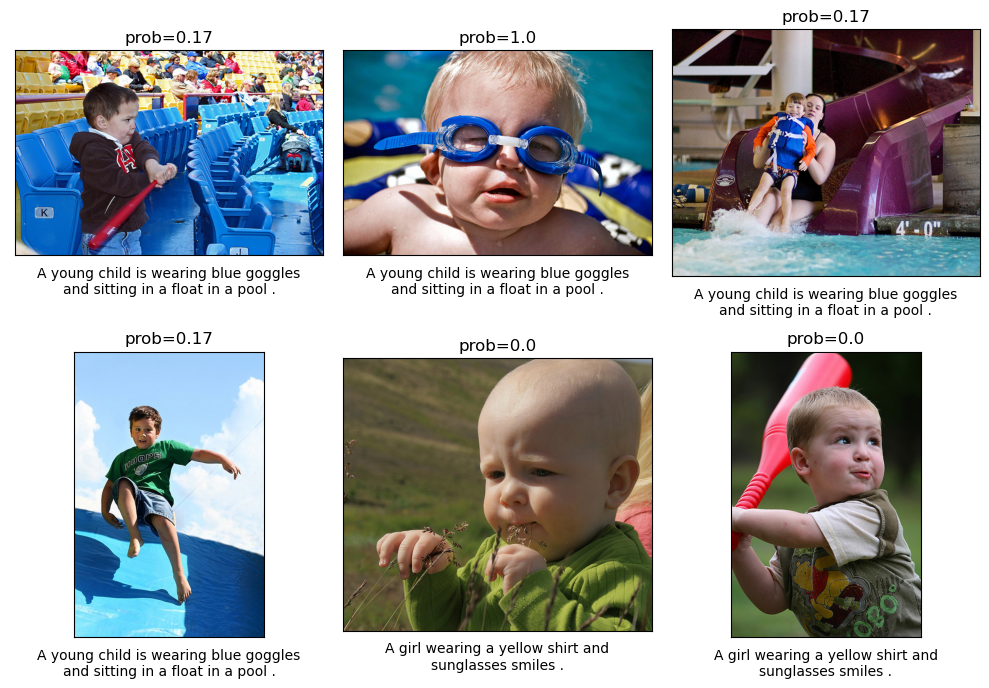

In [76]:
prohibit_images_data = train_data[train_data['image'].isin(prohibit_images) == True]
fig = plt.figure(figsize=(10,10))
for i in range(6):
    fig.add_subplot(3, 3, i+1)
    img_name = prohibit_images_data.iloc[i]['image']
    img_text = prohibit_images_data.iloc[i]['query_text']
    img_text = '\n'.join(wrap(img_text, 40))
    img_target = prohibit_images_data.iloc[i]['target']
    img = mpimg.imread(f'{PATH}/train_images/train_images/{img_name}')
    plt.imshow(img)
    plt.title(f'prob={round(img_target, 2)}')
    plt.xlabel(img_text)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [77]:
# Remove all forbidden images from the dataframe
train_data_clear = train_data[train_data['image'].isin(prohibit_images) == False]
train_data_clear.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  target  
0  A young child is wearing blue goggles and sitt...     0.0  
1  A young child is wearing blue goggles and sitt...     0.0  
4  A young child is wearing blue goggles and sitt...     0.0  
6  A young child is wearing blue goggles and sitt...     0.0  
7  A young child is wearing blue goggles and sitt...     0.0

In [78]:
print('Number of objects in the dataset cleared of forbidden words:', train_data_clear.shape[0])

Количество объектов в очищенном от запрещенных слов датасете: 38248


## Image Vectorization

Let's convert photos to vectors using the pre-trained Inception v3 model 

In [79]:
train_data_clear = train_data_clear.drop('query_id', axis=1)

In [80]:
train_data_clear.sample(5)

image  \
46450   430173345_86388d8822.jpg   
44388  3685328542_ab999b83bb.jpg   
27766  3040033126_9f4b88261b.jpg   
2670   3214237686_6566b8b52f.jpg   
40847  3540416981_4e74f08cbb.jpg   

                                              query_text  target  
46450   Dog sniffing another dog lying under furniture .     0.0  
44388  A football player is tackling the player with ...     0.0  
27766  A small white dogs leaps over the back of a la...     0.0  
2670                  A sunset sky over rippling water .     0.0  
40847  A black dog on a beach carrying a ball in its ...     0.0

In [83]:
def image_to_tensor(image_names, data):
    
    # Load the model with pre-trained parameters
    model_extractor = models.inception_v3(pretrained=True)
    # Freeze the weights
    for param in model_extractor.parameters():
        param.requires_grad_(False)

    model_extractor.fc = nn.Identity()
    model_extractor = model_extractor.to(DEVICE)

    # Let's put the model in prediction mode
    model_extractor.eval()

    output_vectors = []
    images_names_list = image_names.values
    preprocess = transforms.Compose([
      transforms.Resize(299),
      transforms.CenterCrop(299),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    if data == 'train':
        folder = 'train_images'
    elif data == 'test':
        folder = 'test_images'

    for img_name in images_names_list:
        try:
            img = Image.open(f"{PATH}/{folder}/{img_name}").convert('RGB')
        except:
            img = Image.open(f"{PATH}/{folder}/{folder}/{img_name}").convert('RGB')
        image_tensor = preprocess(img).unsqueeze(0)
        output_tensor = model_extractor(image_tensor.to(DEVICE)).flatten()
        output_vectors.append(output_tensor.cpu().numpy())
        torch.cuda.empty_cache()
    return np.array(output_vectors)

In [84]:
try:
    train_images_vectors_big = load_from_pkl('train_images_vectors_big')
except:
    train_images_vectors_big = image_to_tensor(image_names=train_data_clear['image'], data='train')
    save_to_pkl(train_images_vectors_big, 'train_images_vectors_big')

Saved to /kaggle/working//train_images_vectors_big.pkl


In [86]:
train_images_vectors_big.shape

(38248, 2048)

## Text Vectorization

Let's vectorize the text using the pre-trained DistilBert model

In [87]:
def text_to_vectors(texts_series):
    tokenizer = tfs.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = tfs.DistilBertModel.from_pretrained('distilbert-base-uncased')
    model.to(DEVICE)

    tokenized = texts_series.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)

    input_ids = torch.tensor(padded).to(DEVICE)
    attention_mask = torch.tensor(attention_mask).to(DEVICE)
    batch_size = 100
    embeddings = []

    for i in range(input_ids.shape[0] // batch_size + 1):
        batch = input_ids[batch_size*i:batch_size*(i+1)]
        attention_mask_batch = attention_mask[batch_size*i:batch_size*(i+1)]

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        torch.cuda.empty_cache()

    features = np.concatenate(embeddings)
    return features

In [88]:
try:
    train_text_vectors_big = load_from_pkl('train_text_vectors_big')
except:
    train_text_vectors_big = text_to_vectors(train_data_clear['query_text'])
    save_to_pkl(train_text_vectors_big, 'train_text_vectors_big')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saved to /kaggle/working//train_text_vectors_big.pkl


In [89]:
train_text_vectors_big.shape

(38248, 768)

## Combining vectors

In [90]:
try: 
    features = load_from_pkl('features')
    target = load_from_pkl('target')
    train_data_clear = load_from_pkl('train_data_clear (1)')
except: 
    features = np.concatenate([train_images_vectors_big, train_text_vectors_big], axis=1)
    target = train_data_clear.target.values
    save_to_pkl(features, 'features')
    save_to_pkl(target, 'target')
    save_to_pkl(train_data_clear, 'train_data_clear')

Saved to /kaggle/working//features.pkl
Saved to /kaggle/working//target.pkl
Saved to /kaggle/working//train_data_clear.pkl


In [91]:
print("Data size", features.shape)
print(target.shape)

Размер данных (38248, 2816)
(38248,)


The vectors of the following sizes were obtained as a result of vectorization:
- For one description: (768,)

- For one image: (2048,)

As a result, the feature space for one object was 2816 features.

Total 38230 objects

## Training a predictive model for matching

Target is a continuous number (though lying in the range from zero to one), we will solve the regression problem. We will use RMSE as a metric. Thus, we will evaluate how much the probability of correctly describing the picture differs from the probability we previously calculated and placed in the target value.

To ensure that the predictions also lie between zero and one, we will set all predicted values below zero to zero and all predicted values above one to one.

For training, we divide the dataset into training and test samples. Simple random partitioning is not suitable: it is necessary to exclude images from both training and test samples. In order to take images into account when splitting, we will use the GroupShuffleSplit class from the sklearn.model_selection library.


In [92]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

train_ind, val_ind = next(splitter.split(features, target, groups=train_data_clear["image"].values))

X_train = features[train_ind]
y_train = target[train_ind]
X_valid = features[val_ind]
y_valid = target[val_ind]

In [93]:
print('Training sample size:', X_train.shape)
print('Testing sample size:', X_valid.shape)

Размер тренировочной выборки: (30288, 2816)
Размер валидационной выборки: (7960, 2816)


### Linear models

In [94]:
def make_it_look_like_probs(pred_raw):
    pred_probs = np.where(pred_raw >= 0, pred_raw, 0)
    pred_probs = np.where(pred_probs <= 1, pred_probs, 1)
    return pred_probs

In [95]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_valid)
y_pred = make_it_look_like_probs(y_pred)
rmse_valid = mean_squared_error(y_valid, y_pred, squared=False)
print(rmse_valid)

0.6699359679957522


In [96]:
en_model = ElasticNet(l1_ratio=0.5)
en_model.fit(X_train, y_train)
y_pred = en_model.predict(X_valid)
y_pred = make_it_look_like_probs(y_pred)
rmse_valid = mean_squared_error(y_valid, y_pred, squared=False)
print(rmse_valid)


0.20333496153496633


We checked the quality of work of two linear models LinearRegression and ElasticNet. 

LinearRegression - showed rather low result RMSE=0.7. ElasticNet has a better result RMSE=0.2. 

However, the errors of these models are too large to use them.

### Neuron net

In [97]:
X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)


In [98]:
print(X_train.dtype)
print(X_train.shape)
print(X_train.is_cuda)

torch.float32
torch.Size([30288, 2816])
False


In [99]:
y_train = torch.FloatTensor(y_train).reshape(y_train.shape[0], 1)
y_valid = torch.FloatTensor(y_valid).reshape(y_valid.shape[0], 1)

In [100]:
print(y_train.dtype)
print(y_train.shape)
print(y_train.is_cuda)

torch.float32
torch.Size([30288, 1])
False


In [101]:
batch_size = 32
dataset = {
    'train': torch.utils.data.TensorDataset(X_train, y_train),
    'valid': torch.utils.data.TensorDataset(X_valid, y_valid)
}
dataloaders = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], batch_size=batch_size, shuffle=False
    ),
}

In [102]:
dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}

In [103]:
# Metric
rmse = MeanSquaredError(squared = False).to(DEVICE)

In [104]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], "valid": []}
    accuracies = {'train': [], 'valid': []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        for phase in ['train', 'valid']:

            running_loss = 0.0
            running_corrects = 0

            if phase == 'train':
                scheduler.step()
                model.train(True)  
            else:
                model.eval()

            for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):

                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                if phase == "train":
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    loss.backward()
                    optimizer.step()

                # forward pass
                if phase == " valid":
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)

                pred = model(inputs)
                running_loss += loss.item()
                running_corrects += rmse(pred, labels).cpu()
                
                del inputs
                del labels
                gc.collect()
                torch.cuda.empty_cache()
                
            if phase == 'train':
                sheduler.step()

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects / dataset_size[phase]

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
            ))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [105]:
def show_metrics_all(losses, accuracies):
    def show_ax(ax_idx, metric, title):
        axes[ax_idx].plot(metric['train'], label='train')
        axes[ax_idx].plot(metric['valid'], label='valid')
        axes[ax_idx].grid()
        axes[ax_idx].legend()
        axes[ax_idx].set_title(title)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    show_ax(0, losses, 'loss')
    show_ax(1, accuracies, 'accuracy')
    plt.show()

In [106]:
n_in_neurons, n_out_neurons = X_train.shape[1], 1

In [107]:
class Net(nn.Module):

    def __init__(self, input_dim=n_in_neurons, num_layers=0, hidden_dim=64, output_dim=n_out_neurons, p=0.0, div=0):
        super().__init__()
        self.layers = torch.nn.Sequential()

        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i),
                                   torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module(f'batchnorm{i}',
                                   torch.nn.BatchNorm1d(hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
            if div!=0 and div!=1:
                hidden_dim = hidden_dim // 2

        self.layers.add_module('classifier', torch.nn.Linear(prev_size, output_dim))


    def forward(self, x):
        return self.layers(x)

In [108]:
model_net = Net(input_dim=n_in_neurons, num_layers=3, hidden_dim=450, output_dim=n_out_neurons, p=0.3, div=3)
model_net.to(DEVICE)
loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model_net.parameters(), lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [109]:
model, losses, accuracies = train_model(model_net, loss, optimizer, sheduler, num_epochs=15)

valid Loss: 0.0010 Acc: 0.0057: 100%|██████████| 15/15 [1:32:07<00:00, 368.49s/it]

Training complete in 92m 7s
Best valid Acc: 0.006069


In [110]:
save_to_pkl(model, 'model_v5')

Saved to /kaggle/working//model_v5.pkl


In [111]:
model

Net(
  (layers): Sequential(
    (layer0): Linear(in_features=2816, out_features=450, bias=True)
    (batchnorm0): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.3, inplace=False)
    (layer1): Linear(in_features=450, out_features=225, bias=True)
    (batchnorm1): BatchNorm1d(225, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.3, inplace=False)
    (layer2): Linear(in_features=225, out_features=112, bias=True)
    (batchnorm2): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.3, inplace=False)
    (classifier): Linear(in_features=112, out_features=1, bias=True)
  )
)

In [112]:
model_cpu = model.cpu()
save_to_pkl(model_cpu, 'model_cpu')

Saved to /kaggle/working//model_cpu.pkl


In [113]:
accuracies['train']= [fl.item() for fl in accuracies['train']]
accuracies['valid']= [fl.item() for fl in accuracies['valid']]

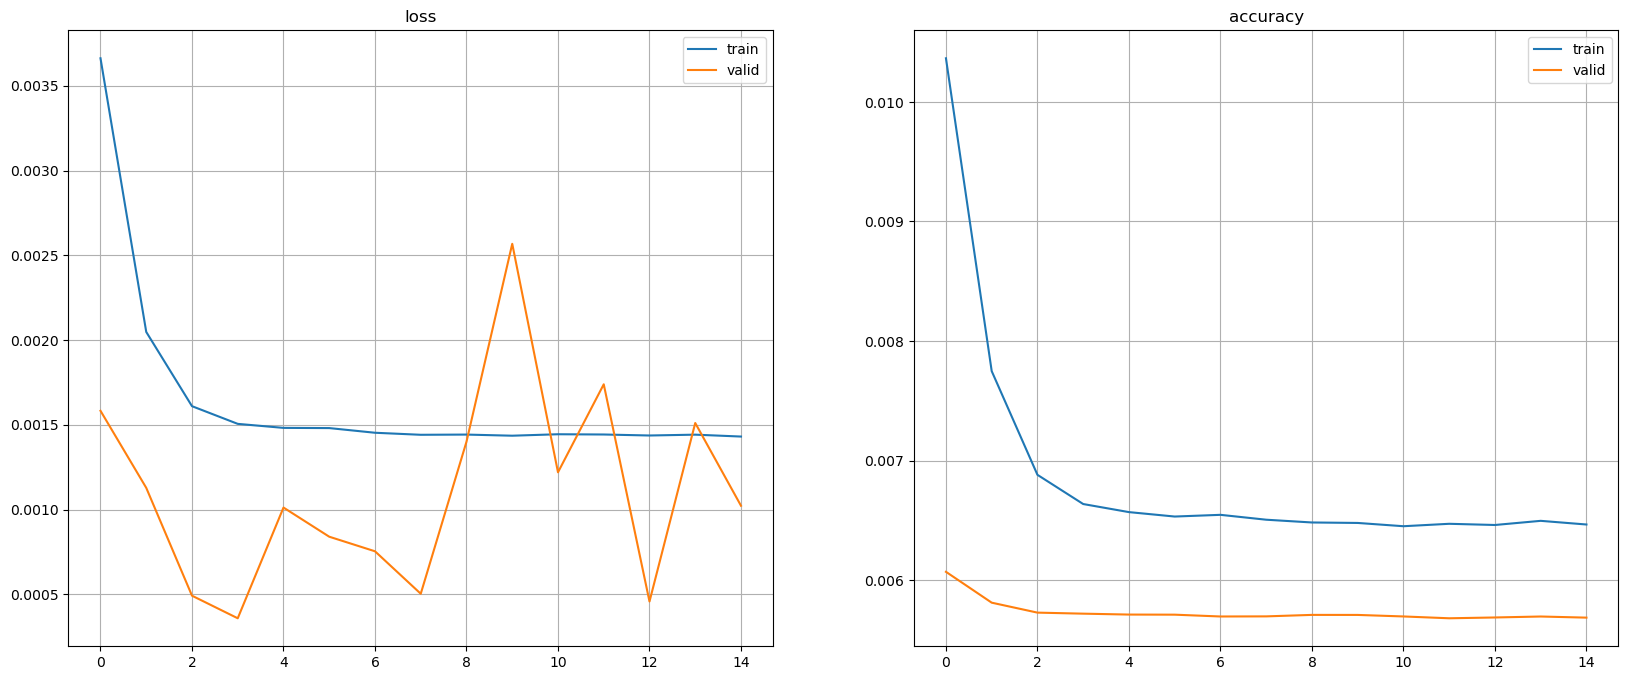

In [114]:
show_metrics_all(losses, accuracies)

The neural network showed an RMSE of approximately 0.06 on the validation sample. Let's use this architecture for testing

## Model testing

In [115]:
# Convert test images to vectors
test_images_vectors = image_to_tensor(image_names=test_images['image'], data='test')

# Get 10 random descriptions
random_queries = test_queries['query_text'].sample(10, random_state=0)

test_images_vectors.shape

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(100, 2048)

In [116]:
# save_to_pkl(test_images_vectors, 'test_images_vectors')
# test_images_vectors = load_from_pkl('test_images_vectors')

Saved to /kaggle/working//test_images_vectors.pkl


In [118]:
random_queries = test_queries['query_text'].sample(10, random_state=0)

In [119]:
# A function that shows a disclaimer if the description falls under restrictions
def show_disclaimer(string, prohibit_wordlist):
    prohibit_wordlist = prohibit_wordlist
    lst = string.split(' ')
    if len(set(lst).intersection(set(prohibit_wordlist))) != 0:
        print('You asked for:', string)
        print('This image is unavailable in your country in compliance with local laws.')
        return True
    else:
        return False

# A function that displays the most relevant images for a text query
def show_related_images(query):
    text = query
    disclaimer = show_disclaimer(text.values[0], prohibit_wordlist)
    if not disclaimer:
        # Convert text to vector
        text_vector = text_to_vectors(text)
        # Get an array with a vector of text, with the number of rows equal to the number of images
        text_vector_array = np.full((test_images_vectors.shape[0], text_vector.shape[1]), text_vector)
        # Concatenate the vectors of all their images with the vector of the description text and convert to a tensor
        image_text_vectors = np.concatenate([test_images_vectors, text_vector_array], axis=1)
        image_text_vectors_t = torch.FloatTensor(image_text_vectors)
  
        # Predict the probability of matching text and image for all images and the given description text
        model.eval()
        model.cpu()
        pred = model(image_text_vectors_t).flatten()
        pred_probs = make_it_look_like_probs(pred.detach().cpu().numpy())
  
        # Get the indices of the four highest probabilities
        ind = np.argpartition(pred_probs, -4)[-4:]
        # Get the four highest probabilities
        top_probs = pred_probs[ind]
        # Obtain four images for which the model predicted the most likely match with the text
        top_images = test_images.values[ind].flatten()

        # Displaying images
        fig = plt.figure(figsize=(5, 5))
        plt.suptitle(*text.values, y=1.05)
        for i in range(4):
            fig.add_subplot(2, 2, i+1)
            img_name = top_images[i]
            img_target = top_probs[i]
            img = mpimg.imread(f'{PATH}/test_images/test_images/{img_name}')
            plt.imshow(img)
            plt.xlabel(f'prob={img_target}')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()

You asked for: A boy plays basketball .
This image is unavailable in your country in compliance with local laws.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


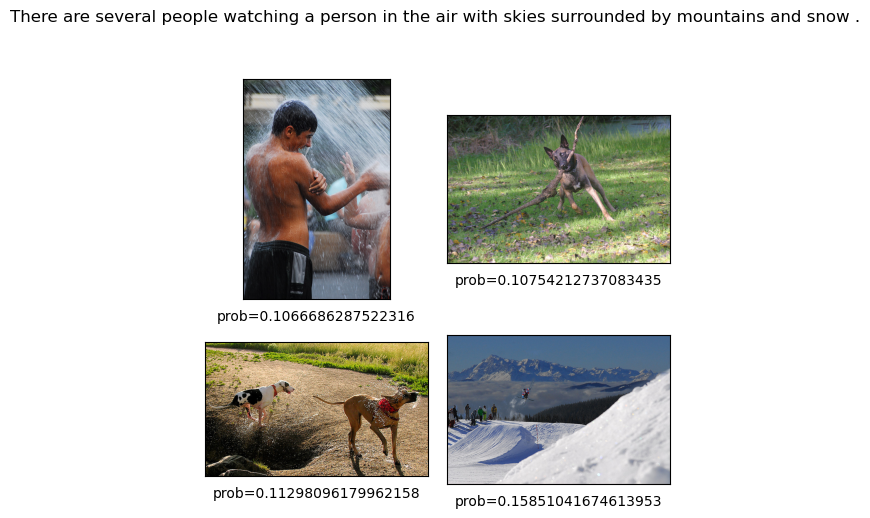

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


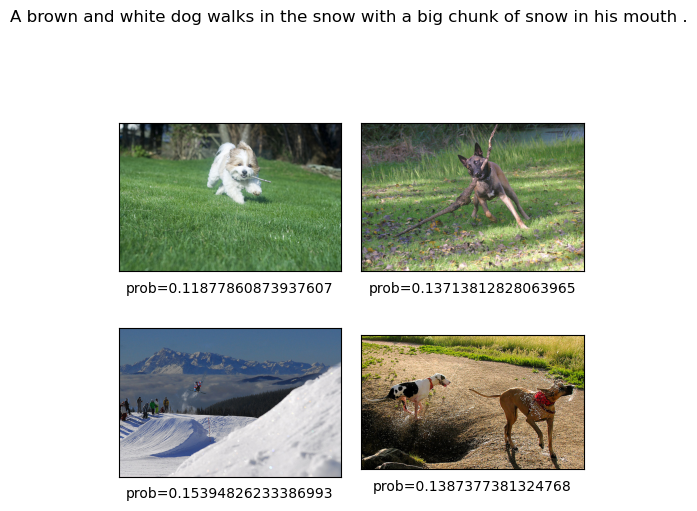

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


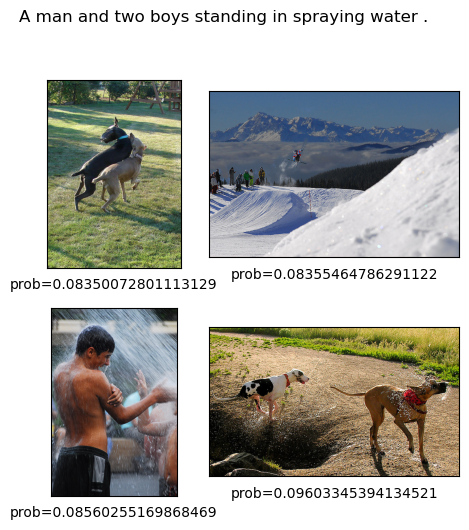

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


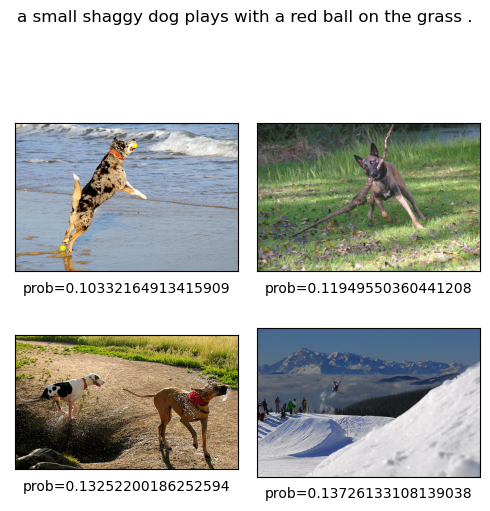

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


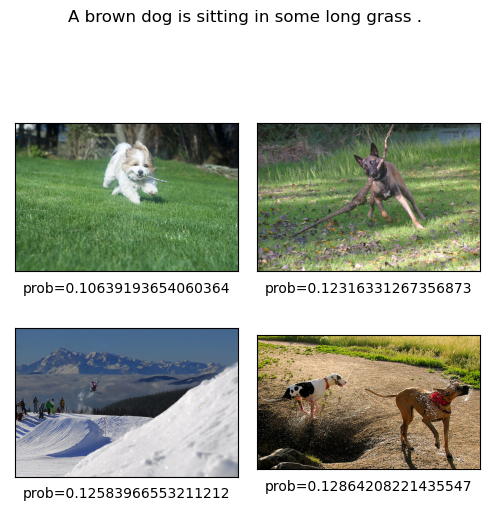

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


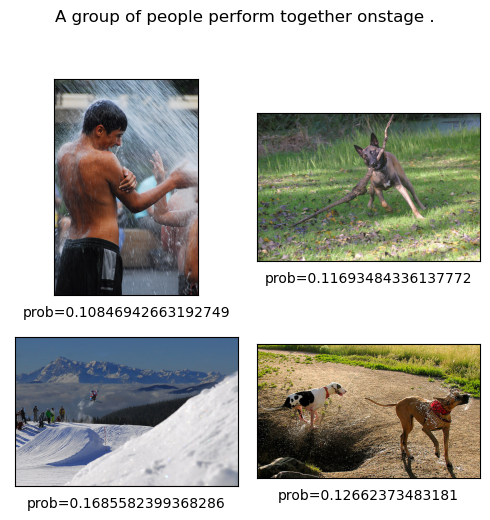

You asked for: I child slides into a wading pool full of water while an adult tosses a bucket of water on them .
This image is unavailable in your country in compliance with local laws.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


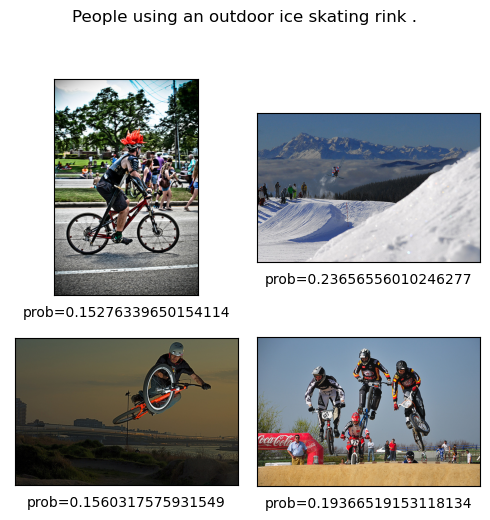

In [120]:
for i in range(9):
    show_related_images(query=random_queries[0+i:1+i])

## Conclusions

The goal of this work was to create a model that should select the most relevant images based on the text description.

Expert and crowdsourcing evaluations were aggregated and based on them a targeting score - a score of similarity between the description and the image - was constructed. The score ranges from zero to one. It was adopted to solve the regression problem. The quality metric is RMSE. 

The performance of linear regression was checked, which showed not very good result.

The next step was to check the performance of the neural network. The quality it showed after 15 epochs of training seemed satisfactory, approximately 0.06 rmse. However, when checked on the test data, the model showed average quality. In general, it produced images where the context was similar to the description, but the similarity was only remote. One way the model could be improved would be to make sure that for each image (as well as each text description), the same number of pairs labeled as "more likely to match" and "more likely not to match" are presented. An imbalance, when we concatenate vectors in this way, could cause the model to overtrain for certain images or descriptions.
